In [1]:
import numpy as np
import xarray as xr
from matplotlib import  pyplot as plt
import pandas as pd
import urllib
import cartopy.crs as ccrs
import datetime
from matplotlib import ticker
import os, sys
import pickle
import glob
from scipy.optimize import minimize
from os import path
from datetime import timedelta
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter
import WetBulb
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon

# Figures 5-6

## Load data

In [2]:
col_names = ['stncodes','stnlats','stnlons','stnelevs']
stndata = pd.read_csv('/home/ivanov/matlab/Code/MJO_TW/hadisd_station_metadata_v2019.txt', delimiter = '\s+', header = None, names = col_names)

# Get individual pieces of station data
stncodes = stndata.stncodes.values
stnlats = stndata.stnlats.values
stnlons = stndata.stnlons.values
stnelevs = stndata.stnelevs.values

In [3]:
# Load fixed station data to plot
path = '/dx01/ivanov/data/HadISD_stationdata/Spice/global_plot_data/'
all_files = glob.glob(os.path.join(path , "*.csv"))

for i in np.arange(len(all_files)):
    if i == 0:
        filename = all_files[i]
        file = filename.rsplit('/', 1)[-1]
        column = file.rsplit('.', 1)[0]
        df = pd.read_csv(filename, index_col=None, header=None)
        dfcols = df.rename(columns={0: column})
    else:
        filename = all_files[i]
        file = filename.rsplit('/', 1)[-1]
        column = file.rsplit('.', 1)[0]
        df_toadd = pd.read_csv(filename, index_col=None, header=None)
        dfcols[column] = df_toadd[0]

In [4]:
# Add old station data to new station data into one dataframe
dfcol_first = dfcols.iloc[:,0:int(len(all_files)/2)]
dfcol_sec = dfcols.iloc[:,int(len(all_files)/2):]

dfcol = 0*dfcols.iloc[:,0:int(len(all_files)/2)]

for i in range(int(len(all_files)/2)):
    
    dfcol.iloc[:,i] = dfcols.iloc[:,i].add(dfcols.iloc[:,i + int(len(all_files)/2)], fill_value = 0)

## Prepare plotting elements

In [6]:
# Create colormap for difference plots
from matplotlib.colors import LinearSegmentedColormap

small_color = 'orangered'
large_color = 'darkblue'

cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

In [9]:
TW_99 = xr.open_dataset("/dx01/ivanov/data/ERA5/stickiness/TW_99.nc")
TW_JJA_99 = xr.open_dataset("/dx01/ivanov/data/ERA5/stickiness/TW_JJA_99.nc")
TW_DJF_99 = xr.open_dataset("/dx01/ivanov/data/ERA5/stickiness/TW_DJF_99.nc")

In [10]:
# Generate mask
file = '/dx01/ivanov/data/dtm_curvature_merit.dem_m_1km_s0..0cm_2017_v1.0.tif'
sftlf_ref = xr.open_rasterio(file).isel(band=0)
sftlf_ref = sftlf_ref.load()
sftlf_ref = sftlf_ref.rename({'y':'lat','x':'lon'})

# Do this in numpy instead of xarray; which is terrible at indexing
# Replacing all ocean pixels (nans in the DEM) with 0, all land pixels with 1
sftlf_tmp = sftlf_ref.values.flatten()
sftlf_tmp[sftlf_tmp>-30000] = 1
sftlf_tmp[sftlf_tmp<-30000] = 0

# Recreate the original dataarray
sftlf_ref = xr.DataArray(sftlf_tmp.reshape(sftlf_ref.shape),coords=[sftlf_ref.lat,sftlf_ref.lon],dims=['lat','lon'])

In [11]:
sftlf_ref = sftlf_ref.isel(lat=slice(0,17920)).coarsen(lon=40,lat=40).mean()

In [12]:
# Convert longitudes
lons = np.array(sftlf_ref.lon)

lon_final = np.zeros_like(lons)

for i in range(len(lons)):
    lon = lons[i]
    
    if lon >= 0:
        lon_final[i] = lon
        
    if lon < 0:
        change = 180 + lon
        lon_final[i] = 180 + change

In [13]:
# Adjust coordinates for longitude to match TW form
sftlf_new = sftlf_ref.assign_coords(lon=lon_final)

# Create mask
mask_grid = sftlf_new.interp(lat=TW_99.latitude, lon = TW_99.longitude)
mask = mask_grid.fillna(0)

In [14]:
masked_TW_JJA = TW_JJA_99.TW.where(mask.values.transpose() == 1)
masked_TW_DJF = TW_DJF_99.TW.where(mask.values.transpose() == 1)

In [15]:
masked_TW_JJA.load()
masked_TW_DJF.load()

<xarray.DataArray 'TW' (longitude: 1440, latitude: 721)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
    quantile   float64 0.99

## Plot

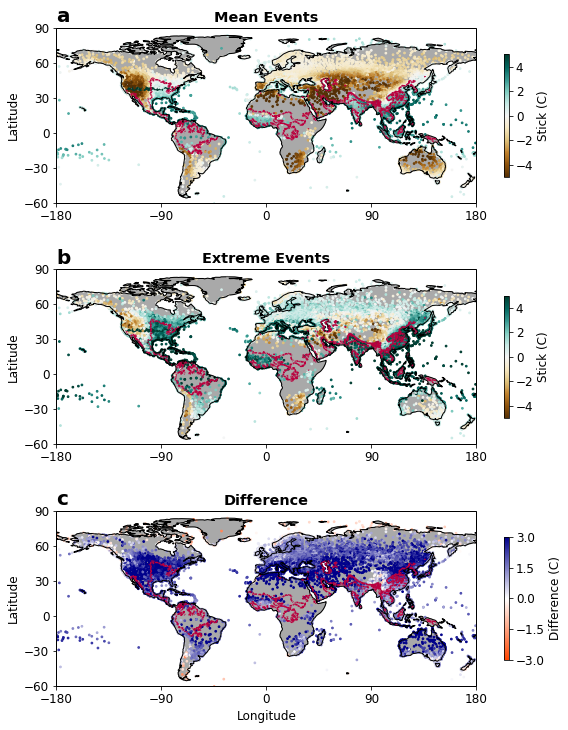

In [17]:
# JJA
import string

plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['JJA_spice','JJA_99th']
clevels = np.arange(26,36+3,3)
plot_titles = ['Mean Events','Extreme Events','Difference']

# Plot
for i, ax in enumerate(fig.axes):
    if i < 2:
        data = dfcol[plot_names[i]]
        color = 'BrBG'
        vmin = -5
        vmax = 5
    if i == 2:
        data = dfcol[plot_names[i-1]] - dfcol[plot_names[i-2]]
        color = cmap
        vmin = -3
        vmax = 3
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = color, vmin = vmin, vmax = vmax)
    cont = ax.contour(masked_TW_JJA.longitude,masked_TW_JJA.latitude, masked_TW_JJA.values.transpose(), colors=('#ba003e',), levels = clevels, linewidths = 1.5)
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    ax.set_title(plot_titles[i], fontweight="bold")
    
    if i < 2:
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Stick (C)')
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Difference (C)')
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')
        
plt.show()

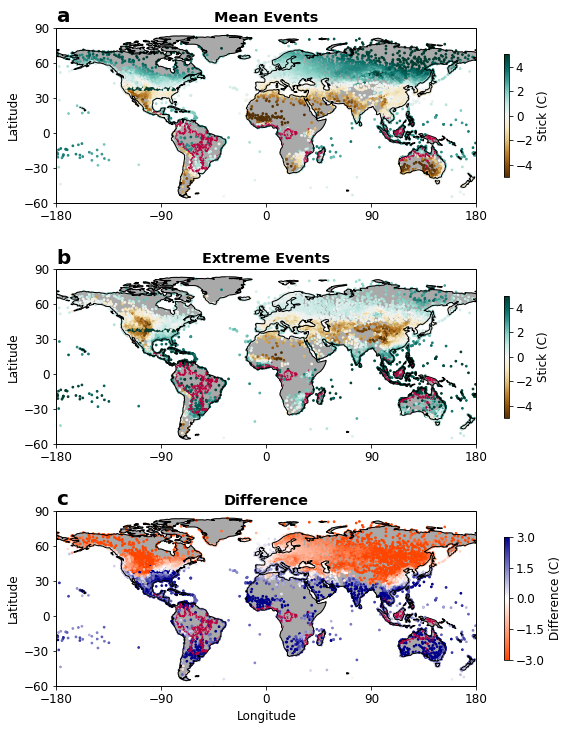

In [18]:
# DJF
fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['DJF_spice','DJF_99th']
clevels = np.arange(27,36+3,3)
plot_titles = ['Mean Events','Extreme Events','Difference']

# Plot
for i, ax in enumerate(fig.axes):
    if i < 2:
        data = dfcol[plot_names[i]]
        color = "BrBG"
        vmin = -5
        vmax = 5
    if i == 2:
        data = dfcol[plot_names[i-1]] - dfcol[plot_names[i-2]]
        color = cmap
        vmin = -3
        vmax = 3
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = color, vmin = vmin, vmax = vmax)
    cont = ax.contour(masked_TW_DJF.longitude,masked_TW_DJF.latitude, masked_TW_DJF.values.transpose(), colors=('#ba003e',), levels = clevels, linewidths = 1.5)
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    ax.set_title(plot_titles[i], fontweight="bold")
    
    if i < 2:
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Stick (C)')
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Difference (C)')
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')
        
plt.show()

# Figures 7-8

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

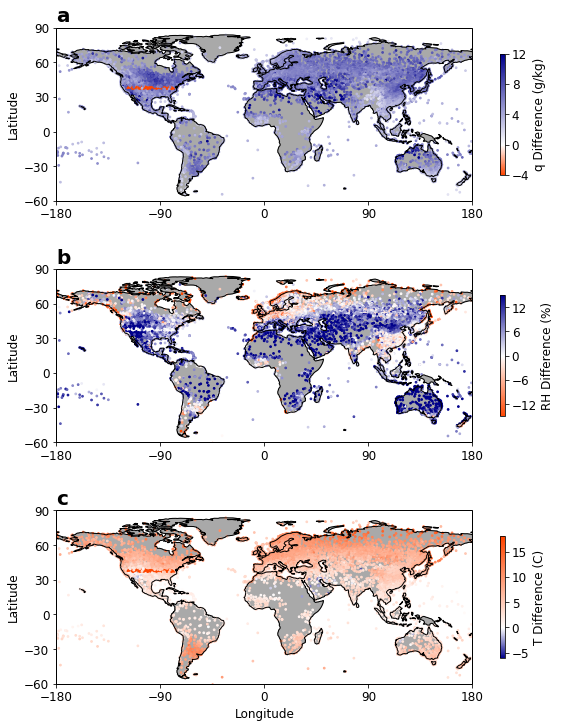

In [20]:
import string

CME_lon = [103, 120]
CME_lat = [22,29]

# Comparison - JJA
fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['JJA_q','JJA_q99','JJA_rh','JJA_rh99','JJA_T','JJA_T99']
label = ['q Difference (g/kg)','RH Difference (%)','T Difference (C)']

cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

# Plot
for i, ax in enumerate(fig.axes):
    ix = 2*i+1
    data = dfcol[plot_names[ix]] - dfcol[plot_names[ix-1]]
    
    if i == 0:
        shifted_qcmap = shiftedColorMap(cmap, midpoint=0.25, name='shiftedq')
        scat = ax.scatter(stnlons,stnlats, c = 1000*data, s = 3, cmap = shifted_qcmap, vmin = -4, vmax = 12)
        
    if i == 1:
        scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = cmap, vmin = -15, vmax = 15)
        
    if i == 2:
        cmap = LinearSegmentedColormap.from_list('mycmap', [large_color, 'white', small_color])
        shifted_Tcmap = shiftedColorMap(cmap, midpoint=0.25, name='shiftedT')
        ax.set_xlabel('Longitude', fontsize = 12)
        scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = shifted_Tcmap, vmin = -6, vmax = 18)
        
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    
    cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label(label[i])
    
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')

plt.show()

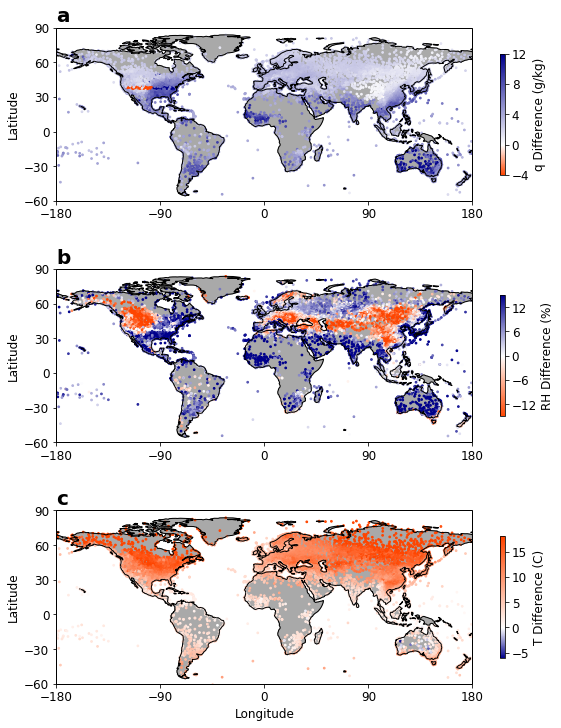

In [21]:
# Comparison - DJF
fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['DJF_q','DJF_q99','DJF_rh','DJF_rh99','DJF_T','DJF_T99']
label = ['q Difference (g/kg)','RH Difference (%)','T Difference (C)']

cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

# Plot
for i, ax in enumerate(fig.axes):
    ix = 2*i+1
    data = dfcol[plot_names[ix]] - dfcol[plot_names[ix-1]]
    
    if i == 0:
        shifted_qcmap = shiftedColorMap(cmap, midpoint=0.25, name='shiftedq')
        scat = ax.scatter(stnlons,stnlats, c = 1000*data, s = 3, cmap = shifted_qcmap, vmin = -4, vmax = 12)
        
    if i == 1:
        scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = cmap, vmin = -15, vmax = 15)
        
    if i == 2:
        cmap = LinearSegmentedColormap.from_list('mycmap', [large_color, 'white', small_color])
        shifted_Tcmap = shiftedColorMap(cmap, midpoint=0.25, name='shiftedT')
        ax.set_xlabel('Longitude', fontsize = 12)
        scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = shifted_Tcmap, vmin = -6, vmax = 18)
        
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    
    cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label(label[i])
    
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')

plt.show()

# Figures S14-S15

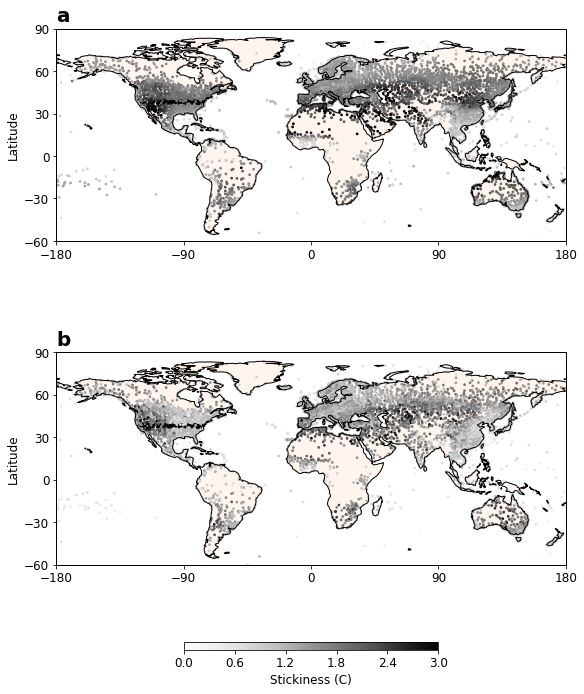

In [23]:
# Stick - JJA
fig, axs = plt.subplots(2,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['JJA_spice_std','JJA_99th_std']

# Plot CME
for i, ax in enumerate(fig.axes):
    
    data = dfcol[plot_names[i]]
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = "Greys", vmin = 0, vmax = 3)   
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'seashell')
        
cbar = plt.colorbar(scat, ax=axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.04)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Stickiness (C)')
plt.show()

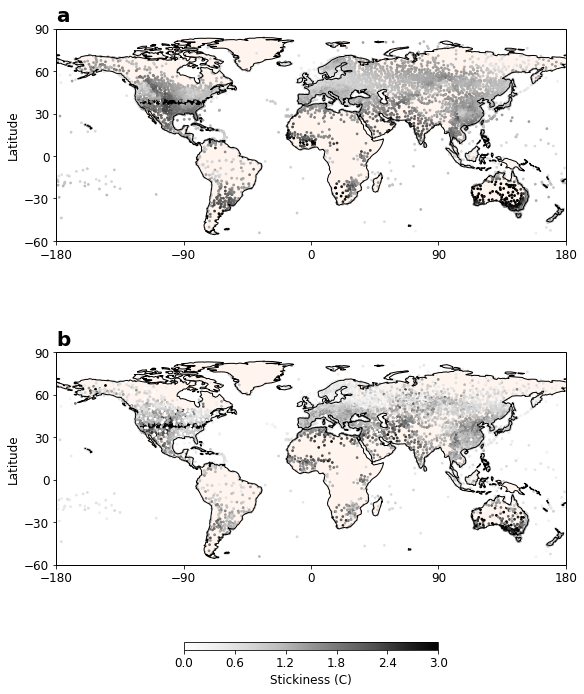

In [24]:
# Stick - JJA
fig, axs = plt.subplots(2,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['DJF_spice_std','DJF_99th_std']

# Plot
for i, ax in enumerate(fig.axes):
    
    data = dfcol[plot_names[i]]
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = "Greys", vmin = 0, vmax = 3)   
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'seashell')
        
cbar = plt.colorbar(scat, ax=axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.04)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Stickiness (C)')
plt.show()

# Figures S18-S19

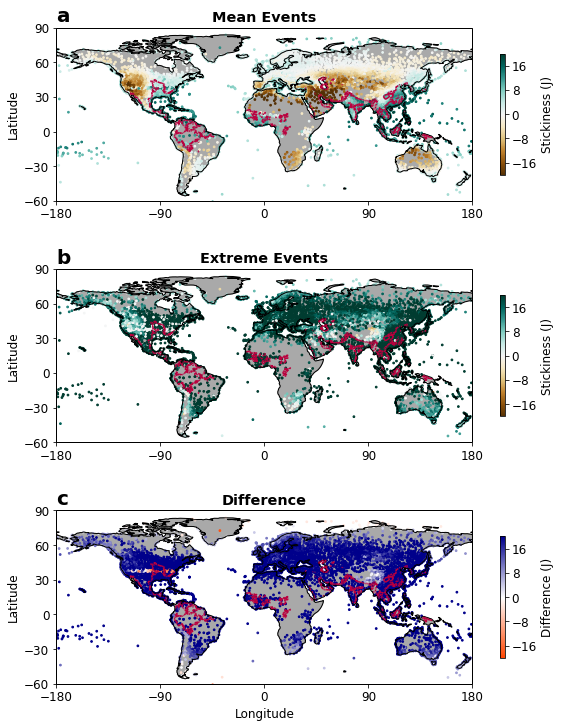

In [25]:
# MSE stickiness -- JJA
fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['JJA_spice_MSE','JJA_99th_MSE']
cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

# Plot 
for i, ax in enumerate(fig.axes):
    if i < 2:
        data = dfcol[plot_names[i]]
        color = 'BrBG'
    if i == 2:
        data = dfcol[plot_names[i-1]] - dfcol[plot_names[i-2]]
        color = cmap
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = color, vmin = -20, vmax = 20)
    cont = ax.contour(masked_TW_JJA.longitude,masked_TW_JJA.latitude, masked_TW_JJA.values.transpose(), colors=('#ba003e',), levels = clevels, linewidths = 1.5)
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    ax.set_title(plot_titles[i], fontweight = 'bold')
    
    if i < 2:
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Stickiness (J)')
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Difference (J)')
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')

plt.show()

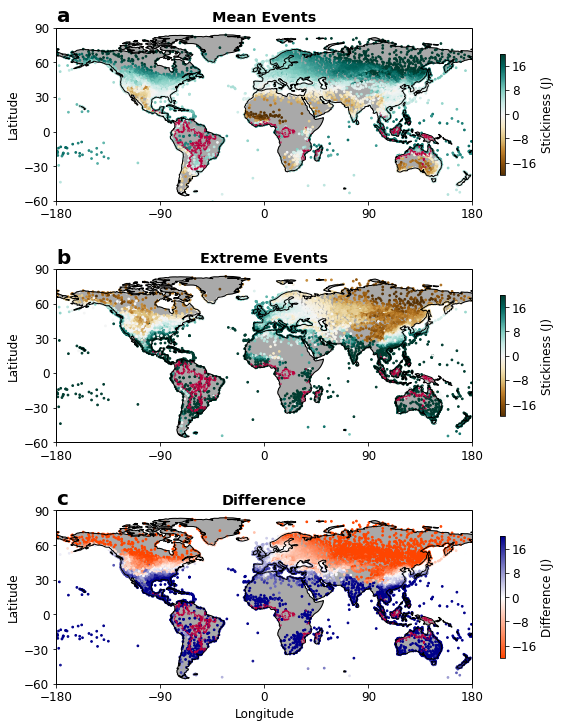

In [26]:
# MSE stickiness -- DJF
fig, axs = plt.subplots(3,1,figsize = (8,10), facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
plot_names = ['DJF_spice_MSE','DJF_99th_MSE']
cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

# Plot 
for i, ax in enumerate(fig.axes):
    if i < 2:
        data = dfcol[plot_names[i]]
        color = 'BrBG'
    if i == 2:
        data = dfcol[plot_names[i-1]] - dfcol[plot_names[i-2]]
        color = cmap
    
    scat = ax.scatter(stnlons,stnlats, c = data, s = 3, cmap = color, vmin = -20, vmax = 20)
    cont = ax.contour(masked_TW_DJF.longitude,masked_TW_DJF.latitude, masked_TW_DJF.values.transpose(), colors=('#ba003e',), levels = clevels, linewidths = 1.5)
    ax.coastlines(linewidth=1)
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.set_xticks([-180,-90,0,90,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude', fontsize = 12)
    ax.set_title(plot_titles[i], fontweight = 'bold')
    
    if i < 2:
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Stickiness (J)')
    
    if i == 2:
        ax.set_xlabel('Longitude', fontsize = 12)
        cbar = plt.colorbar(scat,ax=ax, shrink = 0.7)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label('Difference (J)')
        
    ax.text(-180, 95, string.ascii_lowercase[i], size=20, weight='bold')
    ax.add_feature(cfeature.LAND, facecolor = 'darkgrey')

plt.show()